# Petfinder.my
![](https://3blaws.s3.amazonaws.com/images/3_27.jpg)

## * EDA and ML in progress *

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('fivethirtyeight')

import lightgbm as lgb
import xgboost as xgb

from wordcloud import WordCloud

# Any results you write to the current directory are saved as output.

['train', 'test', 'breed_labels.csv', 'train_sentiment', 'test_sentiment', 'test_metadata', 'train_images', 'train_metadata', 'state_labels.csv', 'color_labels.csv', 'test_images']


### Defining Datatypes

In [167]:
# I am grateful for the help of author of this kernel for the main idea to load the dataset and save memory space!!
# https://www.kaggle.com/theoviel/load-the-totality-of-the-data

train_dtypes = {
        'PetID':                            'str',
        'AdoptionSpeed ':                   'int8',
        'Type':                             'category',
        'Name':                             'str',
        'Age':                              'int8',
        'Breed1':                           'category',
        'Breed2':                           'category',
        'Gender':                           'category',
        'Color1':                           'category',
        'Color2':                           'category',
        'Color3':                           'category',
        'MaturitySize':                     'float16',
        'FurLength':                        'int8',
        'Vaccinated':                       'category',
        'Dewormed':                         'category',
        'Sterilized':                       'category',
        'Health':                           'category',
        'Quantity':                         'uint16',
        'State':                            'uint16',
        'Fee':                              'float',
        'RescuerID':                        'category',
        'VideoAmt':                         'uint16',
        'PhotoAmt':                         'uint16',
        'Description ':                     'str'
        }

breeds_dtypes = {
        'BreedID':                          'category',
        'Type ':                            'category',
        'BreedName':                        'str'
        }

colors_dtypes = {
        'ColorID':                          'category',
        'ColorName':                        'str'
        }

states_dtypes = {
        'StateID':                          'uint16',
        'StateName':                        'str'
        }

In [168]:
breeds = pd.read_csv('../input/breed_labels.csv', dtype=breeds_dtypes)
colors = pd.read_csv('../input/color_labels.csv',  dtype=colors_dtypes)
states = pd.read_csv('../input/state_labels.csv', dtype=states_dtypes)

train = pd.read_csv('../input/train/train.csv', dtype=train_dtypes)
test = pd.read_csv('../input/test/test.csv', dtype=train_dtypes)
sub = pd.read_csv('../input/test/sample_submission.csv')

train['dataset_type'] = 'train'
test['dataset_type'] = 'test'
train_and_test = pd.concat([train, test])

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:11: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  # This is added back by InteractiveShellApp.init_path()


In [169]:
train_and_test.head()

,AdoptionSpeed,Age,Breed1,Breed2,Color1,Color2,Color3,Description,Dewormed,Fee,FurLength,Gender,Health,MaturitySize,Name,PetID,PhotoAmt,Quantity,RescuerID,State,Sterilized,Type,Vaccinated,VideoAmt,dataset_type
0,2.0,3,299,0,1,7,0,Nibble is a 3+ month old ball of cuteness. He ...,2,100.0,1,1,1,1.0,Nibble,86e1089a3,1,1,8480853f516546f6cf33aa88cd76c379,41326,2,2,2,0,train
1,0.0,1,265,0,1,2,0,I just found it alone yesterday near my apartm...,3,0.0,2,1,1,2.0,No Name Yet,6296e909a,2,1,3082c7125d8fb66f7dd4bff4192c8b14,41401,3,2,3,0,train
2,3.0,1,307,0,2,7,0,Their pregnant mother was dumped by her irresp...,1,0.0,2,1,1,2.0,Brisco,3422e4906,7,1,fa90fa5b1ee11c86938398b60abc32cb,41326,2,1,1,0,train
3,2.0,4,307,0,1,2,0,"Good guard dog, very alert, active, obedience ...",1,150.0,1,2,1,2.0,Miko,5842f1ff5,8,1,9238e4f44c71a75282e62f7136c6b240,41401,2,1,1,0,train
4,2.0,1,307,0,1,0,0,This handsome yet cute boy is up for adoption....,2,0.0,1,1,1,2.0,Hunter,850a43f90,3,1,95481e953f8aed9ec3d16fc4509537e8,41326,2,1,2,0,train


In [137]:
train.describe()

,Age,MaturitySize,FurLength,Quantity,Fee,State,VideoAmt,PhotoAmt,AdoptionSpeed
count,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000,14993.000000
mean,10.042286,1.862305,1.467485,1.576069,21.259988,41346.028347,0.056760,3.889215,2.516441
std,17.520097,0.547852,0.599070,1.472477,78.414548,32.444153,0.346185,3.487810,1.177265
min,-124.000000,1.000000,1.000000,1.000000,0.000000,41324.000000,0.000000,0.000000,0.000000
25%,2.000000,2.000000,1.000000,1.000000,0.000000,41326.000000,0.000000,2.000000,2.000000
50%,3.000000,2.000000,1.000000,1.000000,0.000000,41326.000000,0.000000,3.000000,2.000000
75%,11.000000,2.000000,2.000000,1.000000,0.000000,41401.000000,0.000000,5.000000,4.000000
max,123.000000,4.000000,3.000000,20.000000,3000.000000,41415.000000,8.000000,30.000000,4.000000


In [138]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14993 entries, 0 to 14992
Data columns (total 25 columns):
Type             14993 non-null category
Name             13736 non-null object
Age              14993 non-null int8
Breed1           14993 non-null category
Breed2           14993 non-null category
Gender           14993 non-null category
Color1           14993 non-null category
Color2           14993 non-null category
Color3           14993 non-null category
MaturitySize     14993 non-null float16
FurLength        14993 non-null int8
Vaccinated       14993 non-null category
Dewormed         14993 non-null category
Sterilized       14993 non-null category
Health           14993 non-null category
Quantity         14993 non-null uint16
Fee              14993 non-null float64
State            14993 non-null uint16
RescuerID        14993 non-null category
VideoAmt         14993 non-null uint16
Description      14981 non-null object
PetID            14993 non-null category
PhotoAmt 

- We have almost 15 thousands dogs and cats in the dataset;
- Main dataset contains all important information about pets: age, breed, color, some characteristics and other things;
- Desctiptions were analyzed using Google's Natural Language API providing sentiments and entities. I suppose we could do a similar thing ourselves;
- There are photos of some pets;
- Some meta-information was extracted from images and we can use it;
- There are separate files with labels for breeds, colors and states;
- Let's start with the main dataset.

I have also created a full dataset by combining train and test data. This is done purely for more convenient visualization. Column "dataset_type" shows which dataset the data belongs to.

## Exploratory Data Analysis

In [139]:
train.columns

Index(['Type', 'Name', 'Age', 'Breed1', 'Breed2', 'Gender', 'Color1', 'Color2',
       'Color3', 'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed',
       'Sterilized', 'Health', 'Quantity', 'Fee', 'State', 'RescuerID',
       'VideoAmt', 'Description', 'PetID', 'PhotoAmt', 'AdoptionSpeed',
       'dataset_type'],
      dtype='object')

In [153]:
train.shape

(14993, 25)

In [154]:
train_and_test.shape

(18941, 25)

In [142]:
train.AdoptionSpeed.value_counts()

4    4197
2    4037
3    3259
1    3090
0     410
Name: AdoptionSpeed, dtype: int64

In [143]:
train.AdoptionSpeed.value_counts() * 100 / train.shape[0]

4    27.993063
2    26.925899
3    21.736811
1    20.609618
0     2.734609
Name: AdoptionSpeed, dtype: float64

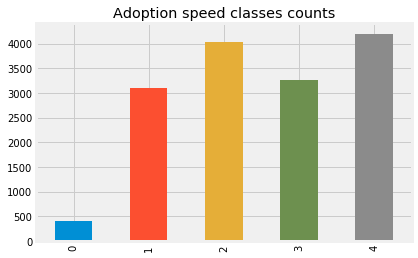

In [166]:
train['AdoptionSpeed'].value_counts().sort_index().plot('bar');
plt.title('Adoption speed classes counts');

We can see that some pets were adopted immediately, but these are rare cases: maybe someone wanted to adopt any pet, or the pet was lucky to be seen by person, who wanted a similar pet. A lot of pets aren't adopted at all, which is quite sad :( I hope our models and analysis will help them to find their home!

It is nice that a lot of pets are adopted within a first week of being listed!

One more interesting thing is that the classes have a linear relationship - the higher the number, the worse situation is. So it could be possible to build not only multiclass classification, but also regression.

### Joining Dataframes
- Train and Test with Breeds

In [145]:
breeds["Breed1"] = breeds.BreedID
#breeds.drop("BreedID", axis="columns", inplace=True)
#breeds.drop("Type", axis="columns", inplace=True)

train_and_test_with_breeds = pd.merge(train_and_test, breeds[["Breed1", "BreedName"]], how= 'left',
                                      on="Breed1")

train_and_test_with_breeds["BreedName_1"] = train_and_test_with_breeds.BreedName
train_and_test_with_breeds.drop("BreedName", axis="columns", inplace=True)

breeds["Breed2"] = breeds.Breed1
train_and_test_with_breeds = pd.merge(train_and_test_with_breeds, breeds[["Breed2", "BreedName"]], how= 'left',
                                      on="Breed2")

train_and_test_with_breeds["BreedName_2"] = train_and_test_with_breeds.BreedName
train_and_test_with_breeds.drop("BreedName", axis="columns", inplace=True)
 
train_and_test_with_breeds.head(4)
#all_data_and_breeds = pd.merge(all_data, breeds, on="")

,AdoptionSpeed,Age,Breed1,Breed2,Color1,Color2,Color3,Description,Dewormed,Fee,FurLength,Gender,Health,MaturitySize,Name,PetID,PhotoAmt,Quantity,RescuerID,State,Sterilized,Type,Vaccinated,VideoAmt,dataset_type,BreedName_1,BreedName_2
0,2.0,3,299,0,1,7,0,Nibble is a 3+ month old ball of cuteness. He ...,2,100.0,1,1,1,1.0,Nibble,86e1089a3,1,1,8480853f516546f6cf33aa88cd76c379,41326,2,2,2,0,train,Tabby,NaN
1,0.0,1,265,0,1,2,0,I just found it alone yesterday near my apartm...,3,0.0,2,1,1,2.0,No Name Yet,6296e909a,2,1,3082c7125d8fb66f7dd4bff4192c8b14,41401,3,2,3,0,train,Domestic Medium Hair,NaN
2,3.0,1,307,0,2,7,0,Their pregnant mother was dumped by her irresp...,1,0.0,2,1,1,2.0,Brisco,3422e4906,7,1,fa90fa5b1ee11c86938398b60abc32cb,41326,2,1,1,0,train,Mixed Breed,NaN
3,2.0,4,307,0,1,2,0,"Good guard dog, very alert, active, obedience ...",1,150.0,1,2,1,2.0,Miko,5842f1ff5,8,1,9238e4f44c71a75282e62f7136c6b240,41401,2,1,1,0,train,Mixed Breed,NaN


In [146]:
train_and_test_with_breeds.shape

(18941, 27)

### Joining Dataframes
- Train and Test and Breeds with Color Dataframe

In [147]:
colors["Color1"] = colors.ColorID
#breeds.drop("BreedID", axis="columns", inplace=True)
#breeds.drop("Type", axis="columns", inplace=True)

train_and_test_with_breeds_colors = pd.merge(train_and_test_with_breeds, colors[["Color1", "ColorName"]], 
                                             how= 'left', on="Color1")

train_and_test_with_breeds_colors["ColorName_1"] = train_and_test_with_breeds_colors.ColorName
train_and_test_with_breeds_colors.drop("ColorName", axis="columns", inplace=True)

colors["Color2"] = colors.ColorID
train_and_test_with_breeds_colors = pd.merge(train_and_test_with_breeds_colors, colors[["Color2", "ColorName"]], 
                                      how= 'left', on="Color2")

train_and_test_with_breeds_colors["ColorName_2"] = train_and_test_with_breeds_colors.ColorName
train_and_test_with_breeds_colors.drop("ColorName", axis="columns", inplace=True)

colors["Color3"] = colors.ColorID
train_and_test_with_breeds_colors = pd.merge(train_and_test_with_breeds_colors, colors[["Color3", "ColorName"]], 
                                      how= 'left', on="Color3")

train_and_test_with_breeds_colors["ColorName_3"] = train_and_test_with_breeds_colors.ColorName
train_and_test_with_breeds_colors.drop("ColorName", axis="columns", inplace=True)
 
train_and_test_with_breeds_colors.head(4)
#all_data_and_breeds = pd.merge(all_data, breeds, on="")

,AdoptionSpeed,Age,Breed1,Breed2,Color1,Color2,Color3,Description,Dewormed,Fee,FurLength,Gender,Health,MaturitySize,Name,PetID,PhotoAmt,Quantity,RescuerID,State,Sterilized,Type,Vaccinated,VideoAmt,dataset_type,BreedName_1,BreedName_2,ColorName_1,ColorName_2,ColorName_3
0,2.0,3,299,0,1,7,0,Nibble is a 3+ month old ball of cuteness. He ...,2,100.0,1,1,1,1.0,Nibble,86e1089a3,1,1,8480853f516546f6cf33aa88cd76c379,41326,2,2,2,0,train,Tabby,NaN,Black,White,NaN
1,0.0,1,265,0,1,2,0,I just found it alone yesterday near my apartm...,3,0.0,2,1,1,2.0,No Name Yet,6296e909a,2,1,3082c7125d8fb66f7dd4bff4192c8b14,41401,3,2,3,0,train,Domestic Medium Hair,NaN,Black,Brown,NaN
2,3.0,1,307,0,2,7,0,Their pregnant mother was dumped by her irresp...,1,0.0,2,1,1,2.0,Brisco,3422e4906,7,1,fa90fa5b1ee11c86938398b60abc32cb,41326,2,1,1,0,train,Mixed Breed,NaN,Brown,White,NaN
3,2.0,4,307,0,1,2,0,"Good guard dog, very alert, active, obedience ...",1,150.0,1,2,1,2.0,Miko,5842f1ff5,8,1,9238e4f44c71a75282e62f7136c6b240,41401,2,1,1,0,train,Mixed Breed,NaN,Black,Brown,NaN


In [148]:
train_and_test_with_breeds_colors.shape

(18941, 30)

 ### Joining Dataframes #3
- Train and Test and Breeds and Colors with States Dataframe

In [155]:
states["State"] = states.StateID
#breeds.drop("BreedID", axis="columns", inplace=True)
#breeds.drop("Type", axis="columns", inplace=True)

train_and_test_with_breeds_colors_states = pd.merge(train_and_test_with_breeds_colors, states[["State", "StateName"]], 
                                             how= 'left', on="State")

'''
train_and_test_with_breeds_colors_states["ColorName_1"] = train_and_test_with_breeds_colors.ColorName
train_and_test_with_breeds_colors.drop("ColorName", axis="columns", inplace=True)

colors["Color2"] = colors.ColorID
train_and_test_with_breeds_colors = pd.merge(train_and_test_with_breeds_colors, colors[["Color2", "ColorName"]], 
                                      how= 'left', on="Color2")

train_and_test_with_breeds_colors["ColorName_2"] = train_and_test_with_breeds_colors.ColorName
train_and_test_with_breeds_colors.drop("ColorName", axis="columns", inplace=True)

colors["Color3"] = colors.ColorID
train_and_test_with_breeds_colors = pd.merge(train_and_test_with_breeds_colors, colors[["Color3", "ColorName"]], 
                                      how= 'left', on="Color3")

train_and_test_with_breeds_colors["ColorName_3"] = train_and_test_with_breeds_colors.ColorName
train_and_test_with_breeds_colors.drop("ColorName", axis="columns", inplace=True)
'''
 
train_and_test_with_breeds_colors_states.head(4)
#all_data_and_breeds = pd.merge(all_data, breeds, on="")

,AdoptionSpeed,Age,Breed1,Breed2,Color1,Color2,Color3,Description,Dewormed,Fee,FurLength,Gender,Health,MaturitySize,Name,PetID,PhotoAmt,Quantity,RescuerID,State,Sterilized,Type,Vaccinated,VideoAmt,dataset_type,BreedName_1,BreedName_2,ColorName_1,ColorName_2,ColorName_3,StateName
0,2.0,3,299,0,1,7,0,Nibble is a 3+ month old ball of cuteness. He ...,2,100.0,1,1,1,1.0,Nibble,86e1089a3,1,1,8480853f516546f6cf33aa88cd76c379,41326,2,2,2,0,train,Tabby,NaN,Black,White,NaN,Selangor
1,0.0,1,265,0,1,2,0,I just found it alone yesterday near my apartm...,3,0.0,2,1,1,2.0,No Name Yet,6296e909a,2,1,3082c7125d8fb66f7dd4bff4192c8b14,41401,3,2,3,0,train,Domestic Medium Hair,NaN,Black,Brown,NaN,Kuala Lumpur
2,3.0,1,307,0,2,7,0,Their pregnant mother was dumped by her irresp...,1,0.0,2,1,1,2.0,Brisco,3422e4906,7,1,fa90fa5b1ee11c86938398b60abc32cb,41326,2,1,1,0,train,Mixed Breed,NaN,Brown,White,NaN,Selangor
3,2.0,4,307,0,1,2,0,"Good guard dog, very alert, active, obedience ...",1,150.0,1,2,1,2.0,Miko,5842f1ff5,8,1,9238e4f44c71a75282e62f7136c6b240,41401,2,1,1,0,train,Mixed Breed,NaN,Black,Brown,NaN,Kuala Lumpur


In [151]:
train_and_test_with_breeds_colors_states.shape

(18941, 31)

In [152]:
train_and_test_with_breeds_colors_states.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18941 entries, 0 to 18940
Data columns (total 31 columns):
AdoptionSpeed    14993 non-null float64
Age              18941 non-null int8
Breed1           18941 non-null object
Breed2           18941 non-null object
Color1           18941 non-null category
Color2           18941 non-null object
Color3           18941 non-null object
Description      18927 non-null object
Dewormed         18941 non-null category
Fee              18941 non-null float64
FurLength        18941 non-null int8
Gender           18941 non-null category
Health           18941 non-null category
MaturitySize     18941 non-null float16
Name             17381 non-null object
PetID            18941 non-null object
PhotoAmt         18941 non-null uint16
Quantity         18941 non-null uint16
RescuerID        18941 non-null object
State            18941 non-null uint16
Sterilized       18941 non-null category
Type             18941 non-null category
Vaccinated       18941

### Distriguish between categorical and numerical columns:

In [170]:
categorical_columns = list(train_and_test_with_breeds_colors_states.loc[:, ((train_and_test_with_breeds_colors_states.dtypes =="category") | (train_and_test_with_breeds_colors_states.dtypes =="object"))].columns)
numerical_columns = list(train_and_test_with_breeds_colors_states.loc[:, ~((train_and_test_with_breeds_colors_states.dtypes =="category") | (train_and_test_with_breeds_colors_states.dtypes =="object"))].columns)



In [173]:
categorical_columns.remove("PetID")
categorical_columns.remove("RescuerID")
print(categorical_columns)

['Breed1', 'Breed2', 'Color1', 'Color2', 'Color3', 'Description', 'Dewormed', 'Gender', 'Health', 'Name', 'Sterilized', 'Type', 'Vaccinated', 'dataset_type', 'BreedName_1', 'BreedName_2', 'ColorName_1', 'ColorName_2', 'ColorName_3', 'StateName']


In [174]:
print(numerical_columns)

['AdoptionSpeed', 'Age', 'Fee', 'FurLength', 'MaturitySize', 'PhotoAmt', 'Quantity', 'State', 'VideoAmt']


In [175]:
def categorical_univariate_and_bivariate_stats(feature):
    
    if feature in train_sample.columns:
    
        print("Top 10 most occurred categories for the categorical feature", feature)
        print(train_sample[feature].value_counts().head(10))

        f, axes = plt.subplots(1, 2, figsize=(21, 10))

        train_sample[feature].value_counts().head(10).plot.bar(ax=axes[0], colormap="BrBG")

        train_sample.groupby(["HasDetections", feature]).count()["MachineIdentifier"].unstack(0).sort_values(by=1, axis=0, ascending=False).head(10).plot.bar(ax=axes[1], colormap="coolwarm")
        
        f.suptitle("Categorical feature: "+" Univariate and Bivariate plots against the target variable")
        
    else:
        print("This feature has been removed from dataset due to high NaN rate or highly unbalanced values")
        
        
def logistic_fit(feature):
    
    import warnings
    warnings.filterwarnings("ignore", category=FutureWarning)
    
    from sklearn.metrics import accuracy_score
    from sklearn.metrics import precision_score
    from sklearn.metrics import recall_score
    from sklearn.metrics import f1_score
    from sklearn.metrics import r2_score

    if feature in train_sample.columns:
        
        from sklearn.linear_model import LogisticRegression
        
        f, axes = plt.subplots(1, 2, figsize=(21, 10))

        # test if there is a logistic relationship between the feature1 and the target.
        print()
        print("Fitting a logistic regression model for the feature", feature,"against the target variable")
        
               
        mask = ~train_sample[feature].isnull() & ~train_sample["HasDetections"].isnull()

        logmodel = LogisticRegression(C=1e5, solver='lbfgs')
        
        if feature in categorical_columns:        
            logmodel.fit(train_sample[feature][mask].cat.codes.values.reshape(-1,1), train_sample["HasDetections"][mask])
            predictions = logmodel.predict(train_sample[feature][mask].cat.codes.values.reshape(-1,1))
        else:
            logmodel.fit(train_sample[feature][mask].values.reshape(-1,1), train_sample["HasDetections"][mask])
            predictions = logmodel.predict(train_sample[feature][mask].values.reshape(-1,1))

        from sklearn.metrics import classification_report
        print(classification_report(train_sample["HasDetections"][mask], predictions))
        print("")
        print("accuracy score:", accuracy_score(train_sample["HasDetections"][mask], predictions))
        print("F1 score:", accuracy_score(train_sample["HasDetections"][mask], predictions))
        #print("R^2 score:", r2_score(train_sample["HasDetections"][mask], predictions))

        import scikitplot as skplt
        skplt.metrics.plot_confusion_matrix(train_sample["HasDetections"][mask], predictions, normalize=False,
                                            title = "Confusion matrix for the feature: "+feature+" against the target variable after fitting a logistic regression model",
                                           figsize=(10,8), text_fontsize='medium', cmap="BrBG", ax = axes[0])
        
        
        # import statsmodels.api as sm
        # print()
        # est = sm.Logit(train_sample["HasDetections"][mask], train_sample[feature][mask].cat.codes.values.reshape(-1,1))
        # result1=est.fit()
        # print(result1.summary())
        if feature in categorical_columns:
            axes[1] = plt.scatter(train_sample[feature][mask].cat.codes.values.reshape(-1,1), predictions)
            axes[1] = plt.scatter(train_sample[feature][mask].cat.codes.values.reshape(-1,1), logmodel.predict_proba(train_sample[feature][mask].cat.codes.values.reshape(-1,1))[:,1])
            plt.xlabel(feature)
            plt.ylabel("HasDetections Probability")
            plt.title("Probability of Detecting a Malware vs the "+ feature)
            plt.show()
        else:
            axes[1] = plt.scatter(train_sample[feature][mask].values.reshape(-1,1), predictions)
            axes[1] = plt.scatter(train_sample[feature][mask].values.reshape(-1,1), logmodel.predict_proba(train_sample[feature][mask].values.reshape(-1,1))[:,1])
            plt.xlabel(feature)
            plt.ylabel("HasDetections Probability")
            plt.title("Probability of Detecting a Malware vs the "+ feature)
            plt.show()
        
    else:
        print("This feature has been removed from dataset due to high NaN rate or highly unbalanced values")

In [ ]:
categorical_univariate_and_bivariate_stats(feature="ProductName")
#logistic_fit(feature="ProductName")

In [ ]:
all_data['Type'] = all_data['Type'].apply(lambda x: 'Dog' if x == 1 else 'Cat')
plt.figure(figsize=(10, 6));
sns.countplot(x='dataset_type', data=all_data, hue='Type');
plt.title('Number of cats and dogs in train and test data');

We can see that the rate of dogs in train dataset is higher that in test set. But I don't think the difference is seriuos.

Comparison of rates
From here on I'll compare not only counts of pets in different categories, but also compate adoption speed rates with base ones.

This is how it works:

As we saw earlier the base rate of pets with Adoption speed 0 is 410 / 14993 = 0.027;
Now look at the next graph: there are 6861 cats in train dataset and 240 of them have Adoption Speed 0. So the rate is 240 / 6861 = 0.035;
0.035/0.027 = 1.28, so by splitting out the data to cat vs dog, we can see that cats have a 28% increased chance of adoption speed class 0 over the base rate of adoption;

In [ ]:
### I want to thank https://www.kaggle.com/artgor/exploration-of-data-step-by-step for the following plot:

main_count = train['AdoptionSpeed'].value_counts(normalize=True).sort_index()
def prepare_plot_dict(df, col, main_count):
    """
    Preparing dictionary with data for plotting.
    
    I want to show how much higher/lower are the rates of Adoption speed for the current column comparing to base values (as described higher),
    At first I calculate base rates, then for each category in the column I calculate rates of Adoption speed and find difference with the base rates.
    
    """
    main_count = dict(main_count)
    plot_dict = {}
    for i in df[col].unique():
        val_count = dict(df.loc[df[col] == i, 'AdoptionSpeed'].value_counts().sort_index())

        for k, v in main_count.items():
            if k in val_count:
                plot_dict[val_count[k]] = ((val_count[k] / sum(val_count.values())) / main_count[k]) * 100 - 100
            else:
                plot_dict[0] = 0

    return plot_dict

def make_count_plot(df, x, hue='AdoptionSpeed', title='', main_count=main_count):
    """
    Plotting countplot with correct annotations.
    """
    g = sns.countplot(x=x, data=df, hue=hue);
    plt.title(f'AdoptionSpeed {title}');
    ax = g.axes

    plot_dict = prepare_plot_dict(df, x, main_count)

    for p in ax.patches:
        h = p.get_height() if str(p.get_height()) != 'nan' else 0
        text = f"{plot_dict[h]:.0f}%" if plot_dict[h] < 0 else f"+{plot_dict[h]:.0f}%"
        ax.annotate(text, (p.get_x() + p.get_width() / 2., h),
             ha='center', va='center', fontsize=11, color='green' if plot_dict[h] > 0 else 'red', rotation=0, xytext=(0, 10),
             textcoords='offset points')

In [ ]:
plt.figure(figsize=(18, 8));
make_count_plot(df=all_data.loc[all_data['dataset_type'] == 'train'], x='Type', title='by pet Type')

In [ ]:
fig, ax = plt.subplots(figsize = (16, 12))
plt.subplot(1, 2, 1)
text_cat = ' '.join(all_data.loc[all_data['Type'] == 'Cat', 'Name'].fillna('').values)
wordcloud = WordCloud(max_font_size=None, background_color='white',
                      width=1200, height=1000).generate(text_cat)
plt.imshow(wordcloud)
plt.title('Top cat names')
plt.axis("off")

plt.subplot(1, 2, 2)
text_dog = ' '.join(all_data.loc[all_data['Type'] == 'Dog', 'Name'].fillna('').values)
wordcloud = WordCloud(max_font_size=None, background_color='white',
                      width=1200, height=1000).generate(text_dog)
plt.imshow(wordcloud)
plt.title('Top dog names')
plt.axis("off")

plt.show()